In [5]:
# Parameters 

application = 'Apple_and_Pears'
varname = 'RAIN_BC'
stat = 'sum'
num_quantiles = 3
target_type = f'cat{num_quantiles}'
step = 4
lag_sst = True
max_lag = 6 
hp_tune = True

In [6]:
%load_ext autoreload

In [7]:
%autoreload 2

In [8]:
%matplotlib inline

In [9]:
import sys 
import pathlib

In [10]:
import matplotlib.pyplot as plt 

In [11]:
import numpy as np 
import pandas as pd 
import xarray as xr
import cartopy.crs as ccrs

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold

In [14]:
import autogluon as ag
from autogluon import TabularPrediction as task

In [15]:
np.random.seed(42)

In [16]:
HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd()

### read the target variable 

In [17]:
ipath_target = pathlib.Path(HOME.joinpath(f"research/Smart_Ideas/outputs/targets/application_cases/{application}/SEASONAL/{varname}"))

In [18]:
target = pd.read_csv(ipath_target.joinpath(f"Seasonal_{varname}_{stat}_anomalies_and_Q{num_quantiles}_categories.csv"), index_col=0, parse_dates=True)

In [19]:
target = target.loc[:,[target_type]]

### keep only data post 1981 to enable direct comparison with GCM derived fields 

In [20]:
target = target.loc['1981':,:]

### reads the SSTs, seasonal anomalies, pre-computed 

In [21]:
ipath_sst = pathlib.Path(HOME.joinpath("/media/nicolasf/END19101/data/ERSST/processed"))

In [22]:
lfiles_sst = list(ipath_sst.glob("*.nc")) 

In [23]:
lfiles_sst.sort() 

In [24]:
lfiles_sst[0]

PosixPath('/media/nicolasf/END19101/data/ERSST/processed/ERSST_seasonal_anomalies_1979-03.nc')

In [25]:
lfiles_sst[-1]

PosixPath('/media/nicolasf/END19101/data/ERSST/processed/ERSST_seasonal_anomalies_2020-03.nc')

In [26]:
dset_sst = xr.open_mfdataset(lfiles_sst, concat_dim='time')

In [27]:
dset_sst

,Array,Chunk
Bytes,31.59 MB,64.08 kB
Shape,"(493, 89, 180)","(1, 89, 180)"
Count,1972 Tasks,493 Chunks
Type,float32,numpy.ndarray


In [28]:
dset_sst = dset_sst.sel(time=slice('1981',None))

In [29]:
dset_sst = dset_sst.sel(lat=slice(-60, 40), lon=slice(120, 360-70)) 

In [30]:
dset_sst

,Array,Chunk
Bytes,8.26 MB,17.54 kB
Shape,"(471, 51, 86)","(1, 51, 86)"
Count,2914 Tasks,471 Chunks
Type,float32,numpy.ndarray


### shift the time index in order to align the observed SST at time m - 4 with the observed rainfall at time 0, e.g. OND SST --> FMA precip 

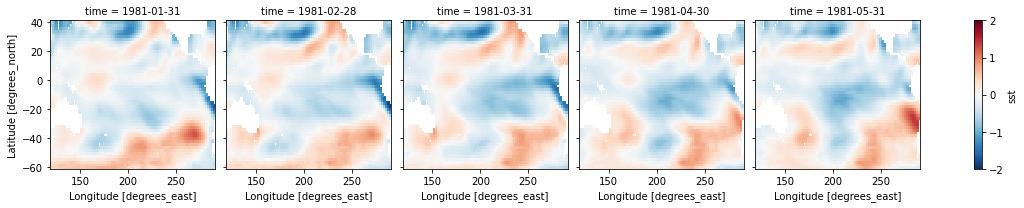

In [31]:
dset_sst.isel(time=slice(0, step + 1))['sst'].plot(x='lon', y='lat', col='time', vmin=-2, vmax=2, cmap='RdBu_r')

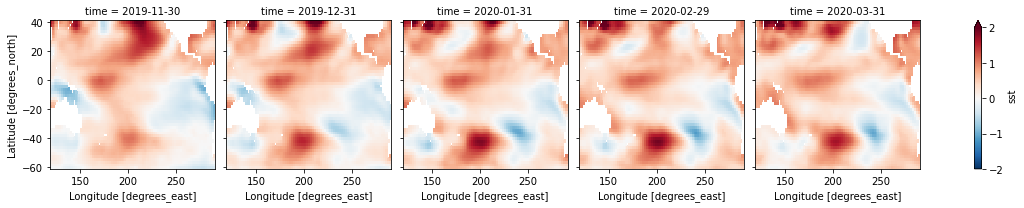

In [32]:
dset_sst.isel(time=slice(-(step + 1), None))['sst'].plot(x='lon', y='lat', col='time', vmin=-2, vmax=2, cmap='RdBu_r')

In [33]:
dset_sst_shift = dset_sst.copy()

In [34]:
dset_sst_shift = dset_sst.shift(time=step)

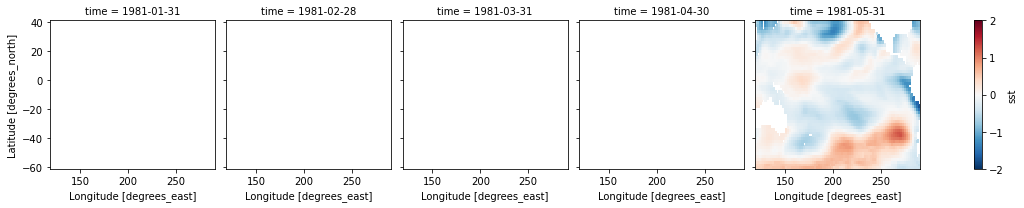

In [35]:
dset_sst_shift.isel(time=slice(0, step + 1 ))['sst'].plot(x='lon', y='lat', col='time', vmin=-2, vmax=2, cmap='RdBu_r')

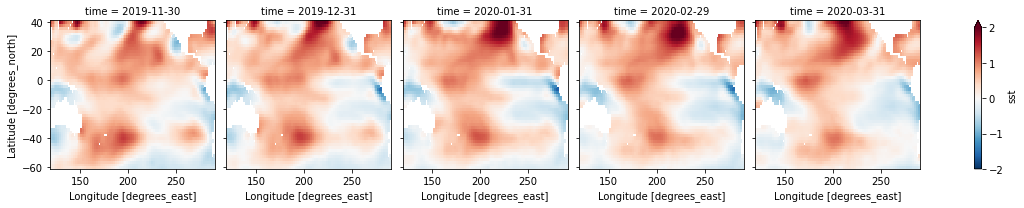

In [36]:
dset_sst_shift.isel(time=slice(-(step + 1), None))['sst'].plot(x='lon', y='lat', col='time', vmin=-2, vmax=2, cmap='RdBu_r')

### calculates the composites

In [37]:
# f, axes = plt.subplots(ncols=3, subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
dset_compos = []
for cat in [1,2,3]: 
    index = target.query(f"cat3 == {cat}")
    dset_compos.append(dset_sst_shift.sel(time=index.index).mean('time')['sst']) 

In [38]:
dset_compos = xr.concat(dset_compos, dim = 'category') 

In [39]:
dset_compos['category'] = (('category'), [1,2,3])

/home/nicolasf/anaconda3/envs/autogluon/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/nicolasf/anaconda3/envs/autogluon/lib/python3.8/site-packages/xarray/plot/utils.py:624: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = fig.colorbar(primitive, **cbar_kwargs)
/home/nicolasf/anaconda3/envs/autogluon/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/nicolasf/anaconda3/envs/autogluon/lib/python3.8/site-packages/xarray/plot/utils.py:624: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar

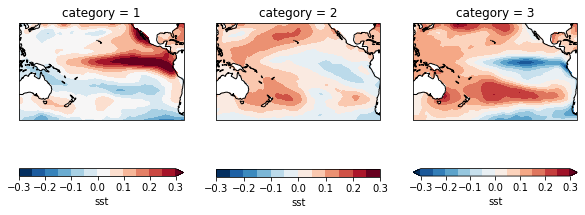

In [40]:
f, axes = plt.subplots(ncols=3, subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)}, figsize=(10, 6))
for cat in [1,2,3]: 
    dset_compos.sel(category=cat).plot.contourf(ax=axes[cat - 1], \
                                                levels=np.arange(-0.3, 0.35, 0.05), \
                                                transform=ccrs.PlateCarree(), \
                                                cbar_kwargs={'orientation':'horizontal'}, \
                                                cmap='RdBu_r')
    axes[cat - 1].coastlines()

### remove the first `step` seasons which are missing 

In [41]:
dset_sst_shift = dset_sst_shift.isel(time=slice(step, None))

In [42]:
dset_sst_shift = dset_sst_shift.stack(s=('lat','lon'))

In [43]:
dset_sst_shift

,Array,Chunk
Bytes,8.19 MB,17.54 kB
Shape,"(467, 4386)","(1, 4386)"
Count,5261 Tasks,467 Chunks
Type,float32,numpy.ndarray


### drop the land points 

In [44]:
dset_sst_shift = dset_sst_shift.dropna('s')

In [45]:
dset_sst_shift.load()

<xarray.Dataset>
Dimensions:  (s: 3981, time: 467)
Coordinates:
  * time     (time) datetime64[ns] 1981-05-31 1981-06-30 ... 2020-03-31
    month    (time) int64 5 6 7 8 9 10 11 12 1 2 3 ... 5 6 7 8 9 10 11 12 1 2 3
  * s        (s) MultiIndex
  - lat      (s) float64 -60.0 -60.0 -60.0 -60.0 -60.0 ... 40.0 40.0 40.0 40.0
  - lon      (s) float64 120.0 122.0 124.0 126.0 ... 284.0 286.0 288.0 290.0
Data variables:
    sst      (time, s) float32 0.42546868 0.45293152 ... 1.0377026 1.1396297

In [46]:
sst_data = dset_sst_shift['sst'].data

In [47]:
sst_data.shape

(467, 3981)

In [48]:
df_sst = pd.DataFrame(sst_data, index=dset_sst_shift.time.to_index())

In [49]:
df_sst

,0,1,2,3,4,5,6,7,8,9,...,3971,3972,3973,3974,3975,3976,3977,3978,3979,3980
time,,,,,,,,,,,,,,,,,,,,,
1981-05-31,0.425469,0.452932,0.445086,0.450316,0.475322,0.539737,0.542407,0.526550,0.528740,0.548263,...,0.509807,0.581705,0.607628,0.593648,0.533564,0.506667,-1.091065,-1.030591,-0.916759,-0.844929
1981-06-30,0.370928,0.395698,0.382532,0.366968,0.372283,0.411084,0.400267,0.383998,0.356813,0.354419,...,0.707175,0.779552,0.809687,0.793489,0.721863,0.687952,-0.684669,-0.676358,-0.618497,-0.563119
1981-07-31,0.192077,0.212412,0.199903,0.176881,0.180434,0.213022,0.209131,0.212409,0.171129,0.157672,...,0.511929,0.646268,0.762092,0.830067,0.803822,0.775673,-0.405702,-0.395685,-0.336811,-0.267130
1981-08-31,0.052004,0.073057,0.070495,0.067105,0.094715,0.151829,0.171223,0.195796,0.170889,0.170496,...,0.244747,0.355242,0.465580,0.521439,0.453079,0.374420,-0.331133,-0.338840,-0.296816,-0.207553
1981-09-30,-0.050947,-0.037916,-0.040765,-0.038309,-0.003810,0.060986,0.090720,0.125933,0.107915,0.111751,...,0.169777,0.224669,0.279029,0.283365,0.177876,0.083774,-0.697181,-0.630045,-0.490177,-0.306935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-30,0.139806,0.165507,0.214928,0.269337,0.318541,0.333053,0.294879,0.246468,0.224448,0.224015,...,0.838111,0.582053,0.382717,0.262774,0.212553,0.241214,1.320290,1.193980,1.021117,0.785675
2019-12-31,0.083776,0.086358,0.105316,0.122533,0.134827,0.120190,0.063494,0.003334,-0.030574,-0.047638,...,1.710595,1.440660,1.152585,0.871248,0.617027,0.482767,1.465768,1.336002,1.164136,0.956868
2020-01-31,0.002080,-0.012536,-0.013261,-0.016449,-0.022417,-0.047975,-0.106200,-0.163115,-0.196911,-0.220356,...,2.115240,1.997016,1.809291,1.557510,1.260005,1.049830,1.361691,1.376684,1.384573,1.300473


### lag ? 

In [50]:
if lag_sst: 
    dset_lagged = pd.concat(
    [df_sst.shift(i).add_suffix(f"_{i}") for i in range(max_lag)], axis=1
    )
    dset_lagged = dset_lagged.dropna()
    df_sst = dset_lagged

### make sure the target is at the right frequency 

In [51]:
target.index.freq = 'M'

In [52]:
target.index

DatetimeIndex(['1981-01-31', '1981-02-28', '1981-03-31', '1981-04-30',
               '1981-05-31', '1981-06-30', '1981-07-31', '1981-08-31',
               '1981-09-30', '1981-10-31',
               ...
               '2019-03-31', '2019-04-30', '2019-05-31', '2019-06-30',
               '2019-07-31', '2019-08-31', '2019-09-30', '2019-10-31',
               '2019-11-30', '2019-12-31'],
              dtype='datetime64[ns]', name='time', length=468, freq='M')

In [53]:
df = pd.concat([df_sst, target], axis=1)

In [54]:
df

,0_0,1_0,2_0,3_0,4_0,5_0,6_0,7_0,8_0,9_0,...,3972_5,3973_5,3974_5,3975_5,3976_5,3977_5,3978_5,3979_5,3980_5,cat3
time,,,,,,,,,,,,,,,,,,,,,
1981-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
1981-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
1981-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1981-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1981-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-30,0.139806,0.165507,0.214928,0.269337,0.318541,0.333053,0.294879,0.246468,0.224448,0.224015,...,0.408832,0.502925,0.583108,0.620982,0.651341,-0.441316,-0.357568,-0.183989,-0.050078,3.0
2019-12-31,0.083776,0.086358,0.105316,0.122533,0.134827,0.120190,0.063494,0.003334,-0.030574,-0.047638,...,0.060864,0.189895,0.300710,0.336517,0.342920,-0.286510,-0.150973,0.076421,0.231688,3.0
2020-01-31,0.002080,-0.012536,-0.013261,-0.016449,-0.022417,-0.047975,-0.106200,-0.163115,-0.196911,-0.220356,...,-0.047256,0.069712,0.156612,0.161158,0.145299,0.191236,0.270978,0.402814,0.438559,NaN


In [55]:
df = df.dropna(axis=0)

In [56]:
df.head()

,0_0,1_0,2_0,3_0,4_0,5_0,6_0,7_0,8_0,9_0,...,3972_5,3973_5,3974_5,3975_5,3976_5,3977_5,3978_5,3979_5,3980_5,cat3
time,,,,,,,,,,,,,,,,,,,,,
1981-10-31,-0.037903,-0.027635,-0.031161,-0.024755,0.015680,0.087785,0.127075,0.171974,0.161534,0.170722,...,0.581705,0.607628,0.593648,0.533564,0.506667,-1.091065,-1.030591,-0.916759,-0.844929,3.0
1981-11-30,-0.088452,-0.074617,-0.073852,-0.063112,-0.019391,0.057738,0.105502,0.159218,0.155047,0.168013,...,0.779552,0.809687,0.793489,0.721863,0.687952,-0.684669,-0.676358,-0.618497,-0.563119,2.0
1981-12-31,-0.083178,-0.057363,-0.040846,-0.009592,0.054980,0.151930,0.218309,0.288859,0.300203,0.328176,...,0.646268,0.762092,0.830067,0.803822,0.775673,-0.405702,-0.395685,-0.336811,-0.267130,2.0
1982-01-31,0.140003,0.196787,0.249345,0.320706,0.423519,0.548384,0.627574,0.705634,0.733831,0.789905,...,0.355242,0.465580,0.521439,0.453079,0.374420,-0.331133,-0.338840,-0.296816,-0.207553,1.0
1982-02-28,0.262600,0.328359,0.388810,0.466164,0.572077,0.695237,0.766572,0.836100,0.861905,0.921259,...,0.224669,0.279029,0.283365,0.177876,0.083774,-0.697181,-0.630045,-0.490177,-0.306935,1.0


In [57]:
df.tail()

,0_0,1_0,2_0,3_0,4_0,5_0,6_0,7_0,8_0,9_0,...,3972_5,3973_5,3974_5,3975_5,3976_5,3977_5,3978_5,3979_5,3980_5,cat3
time,,,,,,,,,,,,,,,,,,,,,
2019-08-31,0.030762,0.075377,0.149820,0.236188,0.318111,0.362172,0.347685,0.314055,0.298182,0.303365,...,0.454943,0.460003,0.517762,0.622570,0.728610,1.166771,1.109354,1.107220,1.186688,2.0
2019-09-30,0.067156,0.120798,0.210210,0.316811,0.419670,0.480790,0.478895,0.456438,0.453703,0.474300,...,0.690517,0.697859,0.734446,0.809492,0.911131,0.242399,0.187085,0.210900,0.311823,2.0
2019-10-31,0.110709,0.154740,0.231048,0.320290,0.404579,0.448335,0.431706,0.398140,0.387827,0.401469,...,0.788737,0.809831,0.831520,0.856492,0.909876,-0.416757,-0.363843,-0.213745,-0.062147,3.0
2019-11-30,0.139806,0.165507,0.214928,0.269337,0.318541,0.333053,0.294879,0.246468,0.224448,0.224015,...,0.408832,0.502925,0.583108,0.620982,0.651341,-0.441316,-0.357568,-0.183989,-0.050078,3.0
2019-12-31,0.083776,0.086358,0.105316,0.122533,0.134827,0.120190,0.063494,0.003334,-0.030574,-0.047638,...,0.060864,0.189895,0.300710,0.336517,0.342920,-0.286510,-0.150973,0.076421,0.231688,3.0


In [58]:
train_data = df.loc[None:'2015-12',:]

In [59]:
test_data = df.loc['2016-01':None, :]

### saved models 

In [60]:
saved_models = pathlib.Path('./saved_models/AUTOGLUON_v3/')

In [61]:
opath = saved_models.joinpath(f'./autogluon_exp_SKPCA_SSTobs_1981_2010_pred_{application}_reg_{varname}_targetvar_{target_type}_target_type')

In [62]:
if not opath.exists(): 
    opath.mkdir(parents=True)

### initialise repeated stratified cross-validation

In [63]:
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=2).split(train_data.drop(labels=[target_type],axis=1).values, train_data.loc[:,target_type].values)

In [64]:
percent_variance = 0.8

In [65]:
nn_options = {  # specifies non-default hyperparameter values for neural network models
    'num_epochs': 10,  # number of training epochs (controls training time of NN models)
    'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)
    'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),  # activation function used in NN (categorical hyperparameter, default = first entry)
    'layers': ag.space.Categorical([100],[1000],[200,100],[300,200,100]),  # each choice for categorical hyperparameter 'layers' corresponds to list of sizes for each NN layer to use
    'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1),  # dropout probability (real-valued hyperparameter)
}

gbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees
    'num_boost_round': 100,  # number of boosting rounds (controls training time of GBM models)
    'num_leaves': ag.space.Int(lower=26, upper=66, default=36),  # number of leaves in trees (integer hyperparameter)
}

hyperparameters = {  # hyperparameters of each model type
                   'GBM': gbm_options,
                   'NN': nn_options,  # NOTE: comment this line out if you get errors on Mac OSX
                  } 

In [66]:
time_limits = 2*60  # train various models for ~2 min
num_trials = 5  # try at most 3 different hyperparameter configurations for each type of model
search_strategy = 'skopt'  # to tune hyperparameters using SKopt Bayesian optimization routine

In [68]:
val_indices = []
y_preds = []
leader_board = []
perfs = []

for k, (train, val) in enumerate(kfold):
    
    print(f"ENTERING FOLD {k} ---- ")
    
    # saves the validation indices
    val_indices.append(val)
    
    ### training data
    
    # get the numpy array containing the training set initial features (grid points)
    X_train = train_data.drop(labels=[target_type],axis=1).values[train]
    
    # get the numpy array containing the training set target values (y)
    y_train =  train_data.loc[:,target_type].values[train]
    
    ### validation data 
    
    # get the numpy array containing the validation set initial features (grid points)
    X_val = train_data.drop(labels=[target_type],axis=1).values[val]
    
    # get the numpy array containing the validation set target values (y)
    y_val = train_data.loc[:,target_type].values[val]
    
    ### test data 
    
    X_test = test_data.drop(labels=[target_type],axis=1).values 
    
    y_test =  test_data.loc[:,target_type].values
    
    # -----------
    # standardize 
    
    # initialise the scaler (standard scaler)
    scaler = StandardScaler() 
    
    # fit on the training set features array, and transform to obtain standardized values
    X_train_std = scaler.fit_transform(X_train)
    
    # apply the transformation on the validation set initial features 
    X_val_std = scaler.transform(X_val)
    
    # apply the transformation on the test set initial features 
    X_test_std = scaler.transform(X_test)
    
    # -----------------------------
    # Principal Component Analysis 
    
    # instantiate the pca class, with percent of variance to keep  
    
    skpca = PCA(n_components=percent_variance)
    
    # fit on the training initial (standardized) fedatures array, and transform to obtain the PCs
    X_train_PC = skpca.fit_transform(X_train_std)
    
    # apply the transformation on the validation set standardized features 
    X_val_PC = skpca.transform(X_val_std)
    
    # apply the transformation on the test set standardized features 
    X_test_PC = skpca.transform(X_test_std)
    
    # assign the training set PCs to a DataFrame 
    df_train = pd.DataFrame(X_train_PC) 
    
    # add the target values to the training DataFrame 
    df_train.loc[:,target_type] = y_train
    
    # assign the validation set Pcs to a DataFrame 
    df_val = pd.DataFrame(X_val_PC) 
    
    # add the target values to the test DataFrame
    df_val.loc[:,target_type] = y_val
 
    # assign the validation set Pcs to a DataFrame 
    df_test = pd.DataFrame(X_test_PC) 
    
    # add the target values to the test DataFrame
    df_test.loc[:,target_type] = y_test    
    
    
    # fit the task predictor on the training set DataFrame 
    
    predictor = task.fit(train_data=df_train, tuning_data=df_val, label=target_type,
                     time_limits=time_limits, num_trials=num_trials,
                     hyperparameter_tune=hp_tune, hyperparameters=hyperparameters,
                     search_strategy=search_strategy)
    
    
    
    # predict the probabilities for each class from the test set features DataFrame (droping the target values column)
#     y_pred_proba = predictor.predict_proba(df_test.drop(labels=[region_name],axis=1))
    
    # predict the class value itself
    y_pred = predictor.predict(df_test.drop(labels=[target_type],axis=1))
    
    # records the probabilities for the classes on the test set 
    y_preds.append(y_pred)
    
    # get the leaderboard DataFrame 
    d = predictor.leaderboard(silent=True)
    
    # records the leaderboard DataFrame 
    leader_board.append(d)
    
    perfs.append(predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True, silent=True))
    
    print(f"EXITING FOLD {k} ---- ")

ENTERING FOLD 0 ---- 


No output_directory specified. Models will be saved in: AutogluonModels/ag-20201028_025835/
Beginning AutoGluon training ... Time limit = 120s
AutoGluon will save models to AutogluonModels/ag-20201028_025835/
AutoGluon Version:  0.0.12
Train Data Rows:    329
Train Data Columns: 22
Tuning Data Rows:    82
Tuning Data Columns: 22
Preprocessing data ...
Here are the 3 unique label values in your data:  [2.0, 1.0, 3.0]
AutoGluon infers your prediction problem is: multiclass  (because dtype of label-column == float, but few unique label-values observed and label-values can be converted to int).
If this is wrong, please specify `problem_type` argument in fit() instead (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])

Train Data Class Count: 3
Feature Generator processed 411 data points with 21 features
Original Features (raw dtypes):
	float32 features: 21
Original Features (inferred dtypes):
	float features: 21
Generated Features (special dtypes):
Final Featu

ValueError: AutoGluon did not successfully train any models

In [ ]:
df_perfs = pd.DataFrame(perfs)

In [ ]:
df_perfs

In [ ]:
df_perfs.mean(0)